In [1]:
import os
import json
import numpy as np
import pandas as pd
import stylia as st

MODELPATH = "../models/"

datasets = ["sarathy2016", "janardhan2016", "radchenko2023", "lepori2025_mtb", "lepori2025_msm"]

def load_report(dataset):
    path = os.path.join(MODELPATH, f"report_{dataset}.json")
    with open(path, "r") as f:
        raw = json.load(f)
    folds = []
    for k in raw.keys():
        y_true = np.asarray(raw[k]["y_true"], dtype=float)
        y_hat  = np.asarray(raw[k]["y_hat"],  dtype=float)
        folds.append((y_true, y_hat))
    return folds

In [2]:
import numpy as np
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(ax, folds, d):
    mean_fpr = np.linspace(0, 1, 200)
    tprs, aucs = [], []

    for y_true, y_hat in folds:
        # guard: drop NaNs if any slipped in
        mask = np.isfinite(y_hat) & np.isfinite(y_true)
        y_true, y_hat = y_true[mask], y_hat[mask]
        fpr, tpr, _ = roc_curve(y_true, y_hat)
        roc_auc = auc(fpr, tpr)
        # interpolate TPR onto a common FPR grid
        tpr_interp = np.interp(mean_fpr, fpr, tpr, left=0.0, right=1.0)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)
        aucs.append(roc_auc)

    tprs = np.vstack(tprs)
    mean_tpr = tprs.mean(axis=0)
    std_tpr  = tprs.std(axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc  = np.std(aucs)

    ax.plot(mean_fpr, mean_tpr, lw=1.5,
            label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})")
    ax.fill_between(mean_fpr,
                    np.maximum(mean_tpr - std_tpr, 0),
                    np.minimum(mean_tpr + std_tpr, 1),
                    alpha=0.25, label="±1 SD")
    ax.plot([0, 1], [0, 1], "--", color="gray", lw=1)
    ax.set_title(f"ROC Curve {d}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right", fontsize=8)


def plot_swarm(ax, y_true, y_hat, d):
    y_true = np.asarray(y_true, dtype=int)
    y_hat  = np.asarray(y_hat,  dtype=float)
    y0 = y_hat[y_true == 0]
    y1 = y_hat[y_true == 1]
    rng = np.random.default_rng(42)
    rng.shuffle(y0); rng.shuffle(y1)

    def jitter(n, center):
        return center + rng.uniform(-0.12, 0.12, size=n)

    ax.scatter(jitter(len(y0), 0), y0, alpha=0.5, s=10, color= "gray", edgecolors="none", label="Neg")
    ax.scatter(jitter(len(y1), 1), y1, alpha=0.5, s=10, color= "red", edgecolors="none", label="Pos")
    ax.set_xlim(-0.5, 1.5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Neg", "Pos"])
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Test labels")
    ax.set_ylabel("Score")
    ax.set_title(f"Scores (one fold) {d}")
    ax.legend(loc="best", fontsize=8)


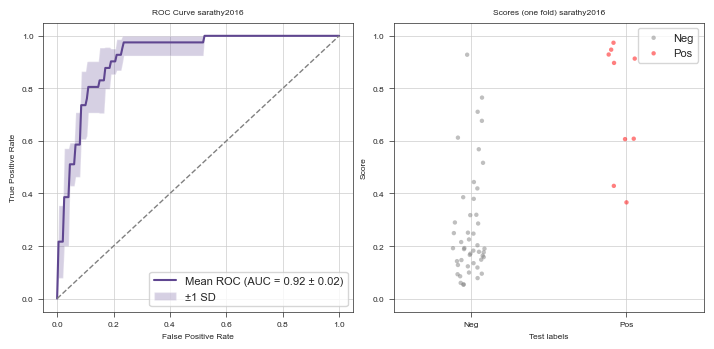

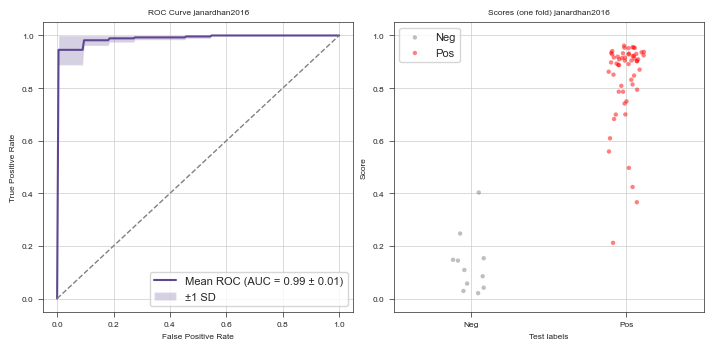

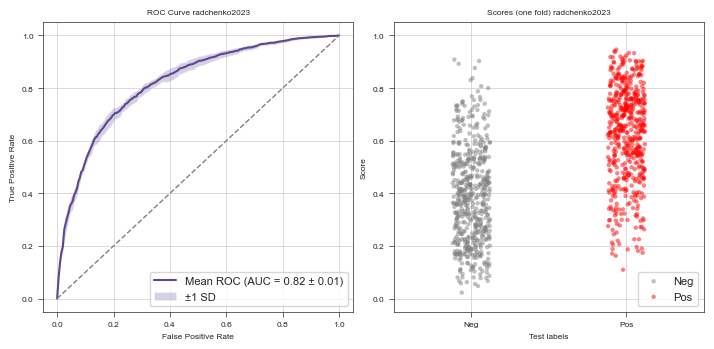

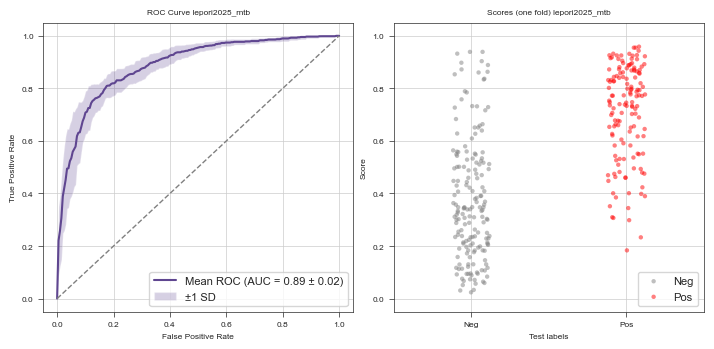

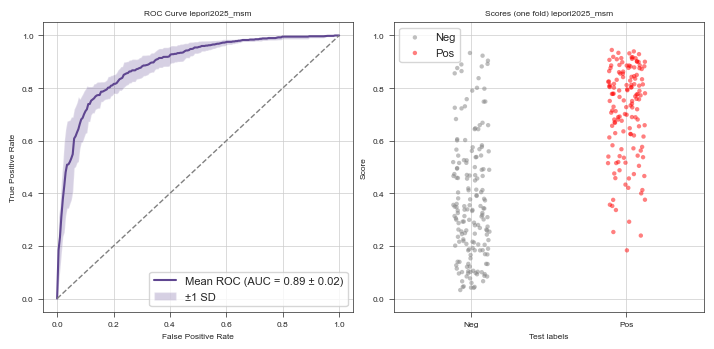

In [4]:
for d in datasets:
    folds = load_report(d)
    fig, axs = st.create_figure(1,2)
    ax = axs.next()
    plot_roc_curve(ax, folds, d)
    ax = axs.next()
    plot_swarm(ax, folds[0][0],folds[0][1], d)
    st.save_figure(f"../output/plots/{d}_performance.png")